In [2]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from scipy import stats
import seaborn as sns
import pandas as pd

from scipy.stats import zscore

from numpy.random import multivariate_normal
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"

/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# Load data and Gaussian mixture model

In [2]:
with open('{}/468202_len128_s2_4cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
# with open('../../../data_GRS1915/468202_len128_s2_4cad_errors_errorfix.pkl', 'rb') as f:
#     segments_errors = pickle.load(f)
# with open('../../../data_GRS1915/468202_len128_s2_4cad_ids_errorfix.pkl', 'rb') as f:
#     id_per_seg = pickle.load(f)

weights_dir = "../../../model_weights/model_2020-04-29_09-12-23.h5"
segments_dir = '../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])

with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)
    
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature


desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
# desc_stats[:,0] = np.median(segments_counts, axis=1).flatten()
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# desc_GM = np.hstack((zscore(desc_stats, axis=0), GMM_bics))

shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [3]:
with open("{}/reconstructions_from_model_2020-04-29_09-12-23.pkl".format(data_dir), 'rb') as f: # output of LSTM autoencoder's decoder
    segment_reconstructions = pickle.load(f)

In [4]:
with open("{}/shape16_moments4_components114_alldata.pkl".format(data_dir), 'rb') as f: # 114 component Gausssian mixture model fit to the 468202 20d samples
    clf_GM114 = pickle.load(f)

/export/data/jakubok/software/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
/export/data/jakubok/software/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.19.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [83]:
with open('{}/shape_moments_GM114_labels.pkl'.format(data_dir), 'rb') as f:
    shape_moments_GM114_labels = pickle.load(f)

# PCA of observations in terms of 114 components

In [4]:
# load observation classifications from Huppenkothen 2017
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state
        
        
# load IDs of segmented light curves: observationsID_segmentIndex
with open('{}/468202_len128_s2_4cad_ids_errorfix.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)

        
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

# make a list of Tomaso classifications for the 468202 segments (including many unknowns)
# i.e. segment_class == ['Unknown','Unknown','Unknown','Unknown','theta',...]
classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")

In [5]:
# make a dictorionary that groups indices of segments of the same observation 
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

In [8]:
# sanity check
bad_keys = []
for k,v in ObID_SegIndices_dict.items():
    if not all(np.take(np.array(seg_ObIDs), v) == k):
        bad_keys.append(k)
print(bad_keys)

KeyboardInterrupt: 

In [84]:
# make a dictionary of Gaussian component indices instead of segment indices  
ObID_GaussComps_dict = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict[ObID] = [shape_moments_GM114_labels[ind] for ind in Indices]

In [85]:
obs_component_counts_df = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict),len(np.unique(shape_moments_GM114_labels)))), index=np.unique(seg_ObIDs), columns=list(range(114)))

In [86]:
for ObID, GaussComps in ObID_GaussComps_dict.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df.loc[ObID][comp_id] = comp_count

In [87]:
from sklearn.preprocessing import Normalizer
normalized_obs_component_counts_df = pd.DataFrame(Normalizer(norm='max').fit_transform(obs_component_counts_df), index=np.unique(seg_ObIDs), columns=list(range(114)))

In [88]:
normalized_obs_component_counts_df

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
10258-01-01-00,0.0,0.0,0.0,0.115023,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009390
10258-01-02-00,0.0,0.0,0.0,0.175355,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014218
10258-01-03-00,0.0,0.0,0.0,0.089445,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10258-01-04-00,0.0,0.0,0.0,0.017380,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001337
10258-01-05-00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
96701-01-51-00,0.0,0.0,0.0,0.026316,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
96701-01-51-01,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
96701-01-52-00,0.0,0.0,0.0,0.274194,0.0,0.000000,0.0,0.016129,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [89]:
from sklearn.decomposition import IncrementalPCA, PCA

n_components = None# segment_encoding.shape[-1]
# ipca = IncrementalPCA(n_components=n_components, batch_size=468202)
pca = PCA(n_components=n_components)

# X_ipca = ipca.fit(segment_encoding[:,0,:])
X_pca = pca.fit(normalized_obs_component_counts_df)

In [90]:
# X_transformed = X_ipca.transform(segment_encoding[:,0,:])
X_transformed = X_pca.transform(normalized_obs_component_counts_df)

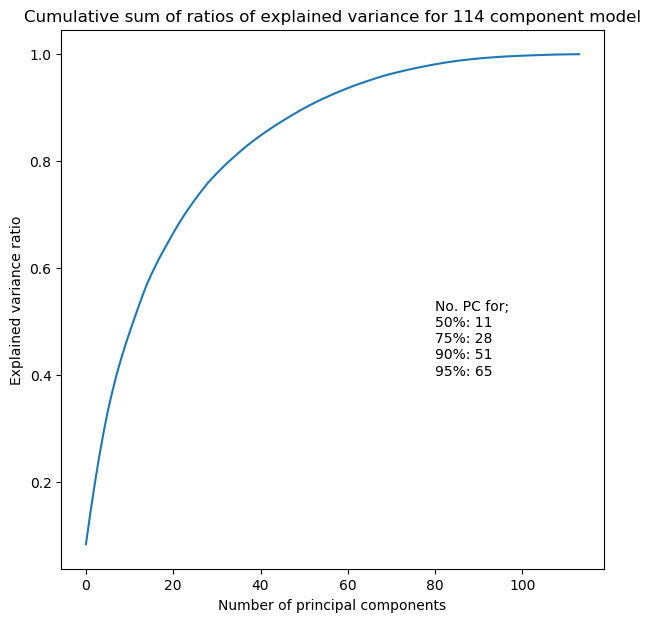

In [94]:
plt.rcParams['figure.figsize'] = [7,7]
cumsum_var_ratio = np.cumsum(X_pca.explained_variance_ratio_)

plt.plot(cumsum_var_ratio)
plt.title("Cumulative sum of ratios of explained variance for 114 component model")
plt.ylabel("Explained variance ratio")
plt.xlabel("Number of principal components")
text = "No. PC for;\n50%: {}\n75%: {}\n90%: {}\n95%: {}".format(np.where(cumsum_var_ratio>0.5)[0][0], np.where(cumsum_var_ratio>0.75)[0][0], np.where(cumsum_var_ratio>0.9)[0][0],np.where(cumsum_var_ratio>0.95)[0][0])
plt.text(x=80, y = 0.4, s=text)
plt.show()

In [20]:
cumsum_var_ratio = np.cumsum(X_pca.explained_variance_ratio_)
print(np.where(cumsum_var_ratio>0.9)[0][0])
print(np.where(cumsum_var_ratio>0.95)[0][0])

51
65


# PCA for 500 components 

In [6]:
with open('{}/shape_moments_GM500_labels.pkl'.format(data_dir), 'rb') as f: # 500 component Gausssian mixture model fit to the 468202 20d samples
    shape_moments_GM500_labels = pickle.load(f)

In [7]:
# make a dictionary of Gaussian component indices instead of segment indices  
ObID_GaussComps_dict_500 = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_500[ObID] = [shape_moments_GM500_labels[ind] for ind in Indices]

In [8]:
shape_moments_GM500_labels

array([458, 278,  30, ..., 358, 450, 400])

In [9]:
obs_component_counts_df_500 = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_500),len(np.unique(shape_moments_GM500_labels)))), index=np.unique(seg_ObIDs), columns=list(range(500)))

In [10]:
for ObID, GaussComps in ObID_GaussComps_dict_500.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_500.loc[ObID][comp_id] = comp_count

In [11]:
from sklearn.preprocessing import Normalizer
normalized_obs_component_counts_df_500 = pd.DataFrame(Normalizer(norm='max').fit_transform(obs_component_counts_df_500), index=np.unique(seg_ObIDs), columns=list(range(500)))

In [65]:
normalized_obs_component_counts_df_500

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
10258-01-01-00,0.000000,0.0,0.062992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.015748,0.0,0.094488,0.0,0.0,0.0,0.0,0.0,0.0
10258-01-02-00,0.000000,0.0,0.236220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.047244,0.0,0.062992,0.0,0.0,0.0,0.0,0.0,0.0
10258-01-03-00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.005714,0.0,0.0,0.0,0.0,0.0,0.0
10258-01-04-00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.022989,0.0,0.0,0.0,0.0,0.0,0.0
10258-01-05-00,0.133333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.019048,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
96701-01-51-00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0
96701-01-51-01,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
96701-01-52-00,0.279070,0.0,0.209302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
from sklearn.decomposition import IncrementalPCA, PCA

n_components = None# segment_encoding.shape[-1]
# ipca = IncrementalPCA(n_components=n_components, batch_size=468202)
pca = PCA(n_components=n_components)

# X_ipca = ipca.fit(segment_encoding[:,0,:])
X_pca = pca.fit(normalized_obs_component_counts_df_500)

In [67]:
# X_transformed = X_ipca.transform(segment_encoding[:,0,:])
X_transformed = X_pca.transform(normalized_obs_component_counts_df_500)

185
249


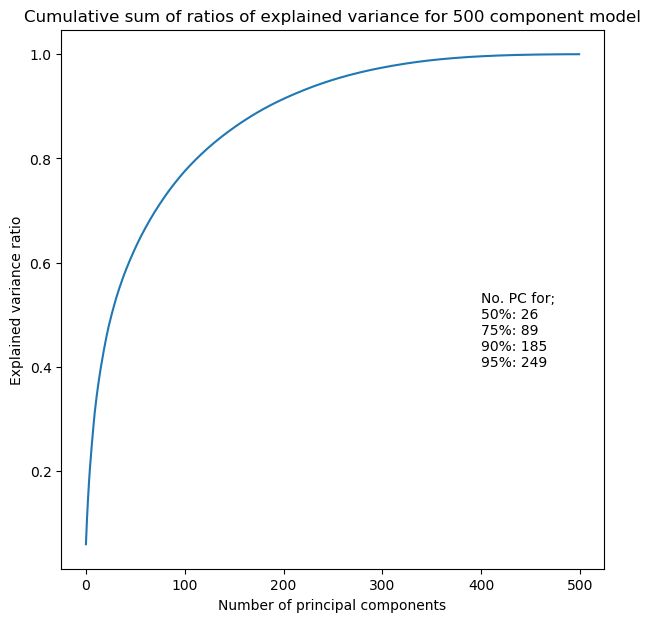

In [77]:
plt.rcParams['figure.figsize'] = [7,7]
cumsum_var_ratio = np.cumsum(X_pca.explained_variance_ratio_)

plt.plot(cumsum_var_ratio)
plt.title("Cumulative sum of ratios of explained variance for 500 component model")
plt.ylabel("Explained variance ratio")
plt.xlabel("Number of principal components")
text = "No. PC for;\n50%: {}\n75%: {}\n90%: {}\n95%: {}".format(np.where(cumsum_var_ratio>0.5)[0][0], np.where(cumsum_var_ratio>0.75)[0][0], np.where(cumsum_var_ratio>0.9)[0][0],np.where(cumsum_var_ratio>0.95)[0][0])
plt.text(x=400, y = 0.4, s=text)
plt.show()

In [36]:
cumsum_var_ratio = np.cumsum(X_pca.explained_variance_ratio_)
print(np.where(cumsum_var_ratio>0.9)[0][0])
print(np.where(cumsum_var_ratio>0.95)[0][0])

185
249


In [63]:
plt.plot(X_pca.explained_variance_ratio_)
plt.xlim([0,120])
plt.show()

NameError: name 'X_pca' is not defined

In [43]:
np.sum(X_pca.explained_variance_ratio_[:50])

0.6240642630660602

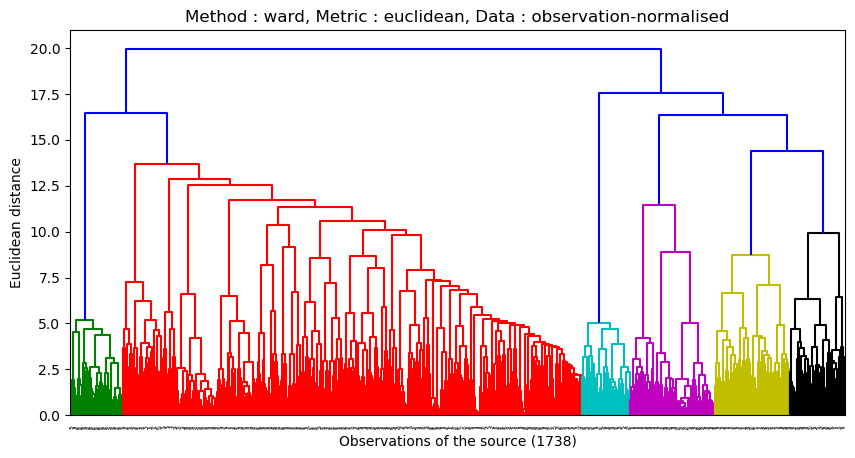

In [44]:
import scipy.cluster.hierarchy as sch
plt.rcParams['figure.figsize'] = [10,5]
method="ward"
metric="euclidean"
linkage = sch.linkage(normalized_obs_component_counts_df_500, method=method, metric=metric)
dendrogram = sch.dendrogram(linkage, truncate_mode=None, p=2, leaf_font_size = 0)
plt.ylabel("Euclidean distance")
plt.xlabel("Observations of the source (1738)")
plt.title("Method : {}, Metric : {}, Data : observation-normalised".format(method, metric))
plt.show()

In [14]:
from sklearn import preprocessing
standardised_obs_component_counts_df_500 = pd.DataFrame(preprocessing.scale(obs_component_counts_df_500, axis=1), index=np.unique(seg_ObIDs), columns=list(range(500)))

In [194]:
standardised_obs_component_counts_df_500

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
10258-01-01-00,-0.192533,-0.192533,0.613888,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,...,-0.192533,0.009072,-0.192533,1.017098,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533
10258-01-02-00,-0.189176,-0.189176,2.804109,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,...,-0.189176,0.409481,-0.189176,0.609034,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176
10258-01-03-00,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,...,-0.144074,-0.144074,-0.144074,-0.061082,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074
10258-01-04-00,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,...,-0.110966,-0.110966,-0.110966,0.216367,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966
10258-01-05-00,1.349320,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,...,-0.200096,0.021249,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,...,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177
96701-01-51-00,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,...,-0.120367,-0.120367,-0.120367,0.407559,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367
96701-01-51-01,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,...,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700
96701-01-52-00,4.811076,-0.136894,3.574083,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,...,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894


In [195]:
from sklearn.decomposition import IncrementalPCA, PCA

n_components = None# segment_encoding.shape[-1]
# ipca = IncrementalPCA(n_components=n_components, batch_size=468202)
pca = PCA(n_components=n_components)

# X_ipca = ipca.fit(segment_encoding[:,0,:])
X_pca = pca.fit(standardised_obs_component_counts_df_500)

In [196]:
# X_transformed = X_ipca.transform(segment_encoding[:,0,:])
X_transformed = X_pca.transform(standardised_obs_component_counts_df_500)

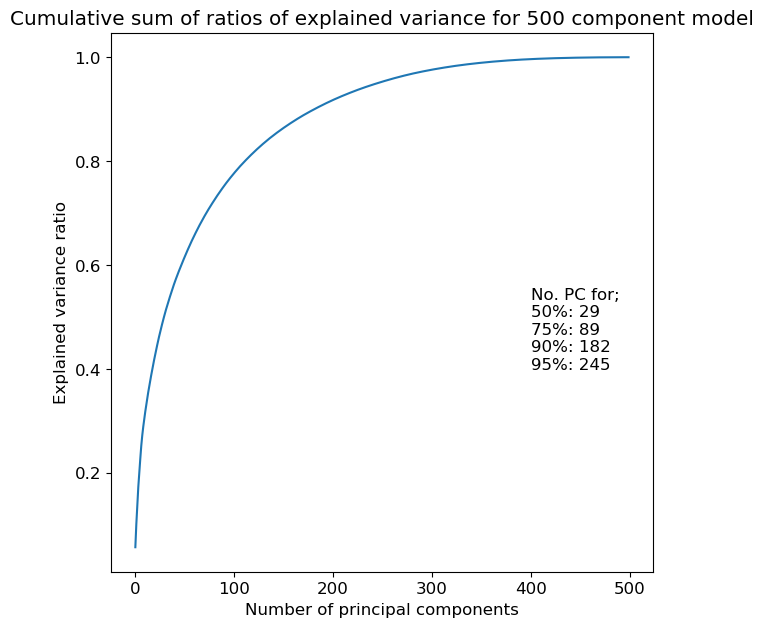

In [197]:
plt.rcParams['figure.figsize'] = [7,7]
cumsum_var_ratio = np.cumsum(X_pca.explained_variance_ratio_)

plt.plot(cumsum_var_ratio)
plt.title("Cumulative sum of ratios of explained variance for 500 component model")
plt.ylabel("Explained variance ratio")
plt.xlabel("Number of principal components")
text = "No. PC for;\n50%: {}\n75%: {}\n90%: {}\n95%: {}".format(np.where(cumsum_var_ratio>0.5)[0][0], np.where(cumsum_var_ratio>0.75)[0][0], np.where(cumsum_var_ratio>0.9)[0][0],np.where(cumsum_var_ratio>0.95)[0][0])
plt.text(x=400, y = 0.4, s=text)
plt.show()

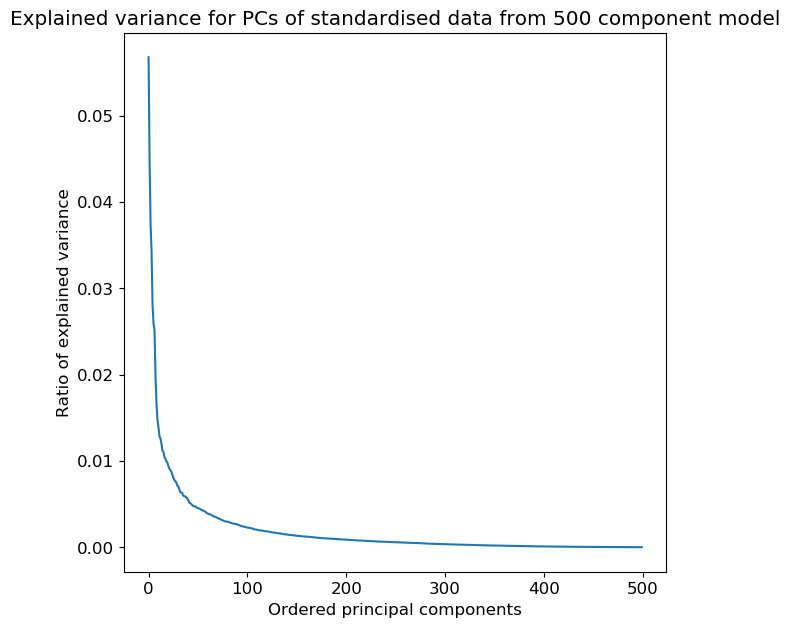

In [201]:
plt.plot(X_pca.explained_variance_ratio_)
plt.title("Explained variance for PCs of standardised data from 500 component model")
plt.ylabel("Ratio of explained variance")
plt.xlabel("Ordered principal components")
plt.show()

In [36]:
cumsum_var_ratio = np.cumsum(X_pca.explained_variance_ratio_)
print(np.where(cumsum_var_ratio>0.9)[0][0])
print(np.where(cumsum_var_ratio>0.95)[0][0])

185
249


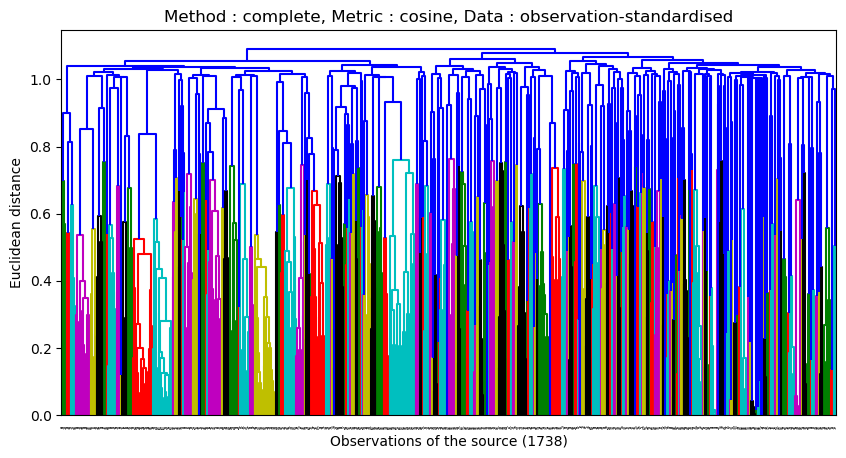

In [16]:
import scipy.cluster.hierarchy as sch
plt.rcParams['figure.figsize'] = [10,5]
method="complete"
metric="cosine"
linkage = sch.linkage(standardised_obs_component_counts_df_500, method=method, metric=metric)
dendrogram = sch.dendrogram(linkage, truncate_mode=None, p=2, leaf_font_size = 0)
plt.ylabel("Euclidean distance")
plt.xlabel("Observations of the source (1738)")
plt.title("Method : {}, Metric : {}, Data : observation-standardised".format(method, metric))
plt.show()

In [17]:
from scipy.cluster.hierarchy import fcluster

no_clusters = []
for distance in np.linspace(0,1.2,1000):
    clusters = fcluster(linkage, distance, criterion='distance')
    no_clusters.append(len(np.unique(clusters)))

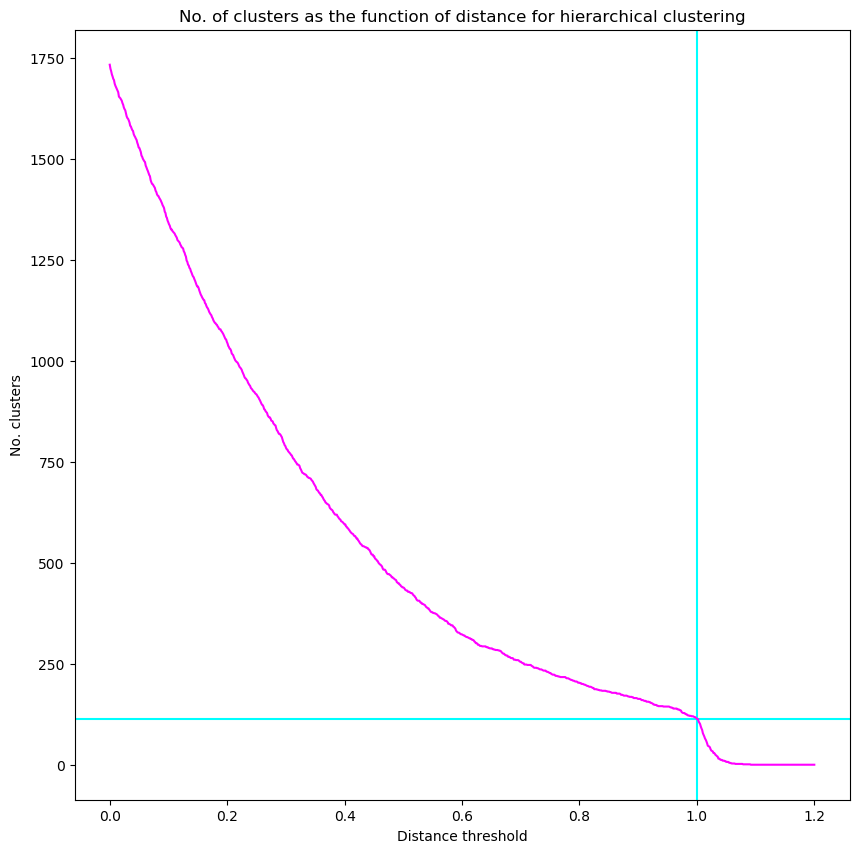

In [27]:
# plt.xlim([1.001, 1.05])
# plt.ylim([0,115])
plt.rcParams['figure.figsize'] = [10,10]

plt.axvline(1.001, c="cyan")
plt.axhline(114, c="cyan")
plt.plot(np.linspace(0,1.2,1000), no_clusters, c="magenta")

# plt.axvline(1.07867868, c="magenta")
# plt.axvline(1.05705706, c="cyan")
# plt.axvline(1.01741742, c="orange")
plt.title("No. of clusters as the function of distance for hierarchical clustering")
plt.ylabel("No. clusters")
plt.xlabel("Distance threshold")
plt.show()

In [98]:
np.unique(cluster_labels)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114], dtype=int32)

In [31]:
cluster_labels = fcluster(linkage, 1.001, criterion='distance')

In [33]:
UMAP_mapper = umap.UMAP(verbose=True, metric="cosine")#n_neighbors=50, min_dist=0.0, local_connectivity, repulsion_strength, negative_sample_rate
UMAP_mapper.fit(obs_component_counts_df_500)
umaped_data = UMAP_mapper.transform(obs_component_counts_df_500)

UMAP(a=None, angular_rp_forest=True, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='cosine',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Thu Aug 13 16:14:55 2020 Finding Nearest Neighbors
Thu Aug 13 16:14:58 2020 Finished Nearest Neighbor Search
Thu Aug 13 16:15:01 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  30

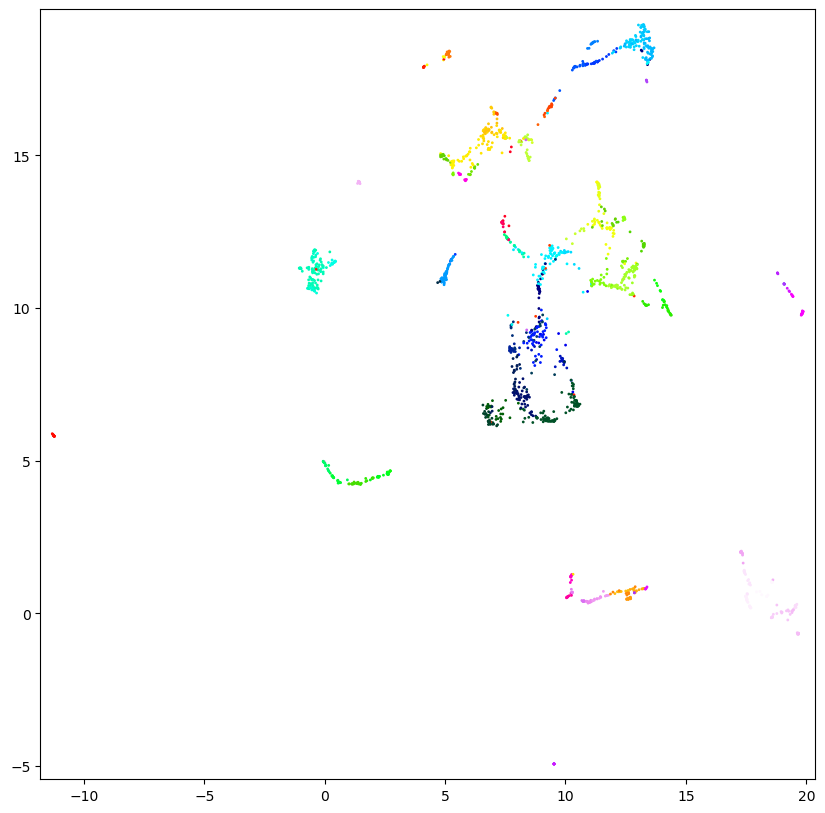

In [37]:
plt.rcParams['figure.figsize'] = [10,10]#(abs((np.min(umaped_data[:,0])-0.5) -(np.max(umaped_data[:,0])+0.5)), abs((np.min(umaped_data[:,1])-0.5)- (np.max(umaped_data[:,1])+0.5)))
plt.scatter(umaped_data[:,0], umaped_data[:,1], s=1, c=cluster_labels, cmap="gist_ncar")
plt.xlim([np.min(umaped_data[:,0])-0.5, np.max(umaped_data[:,0])+0.5])
plt.ylim([np.min(umaped_data[:,1])-0.5, np.max(umaped_data[:,1])+0.5])
plt.show()

In [40]:
Belloni_classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega", "Unknown"])

obs_classes = []
obs_classes_ind = []
for ob in np.unique(seg_ObIDs):
    if ob in ob_state.keys():
        obs_classes.append(ob_state[ob])
        obs_classes_ind.append(np.where(np.array(Belloni_classes) == ob_state[ob])[0][0])
    else:
        obs_classes.append("Unknown")
        obs_classes_ind.append(14)

In [111]:
cluster_labels

array([19, 21, 21, ..., 18, 18, 25], dtype=int32)

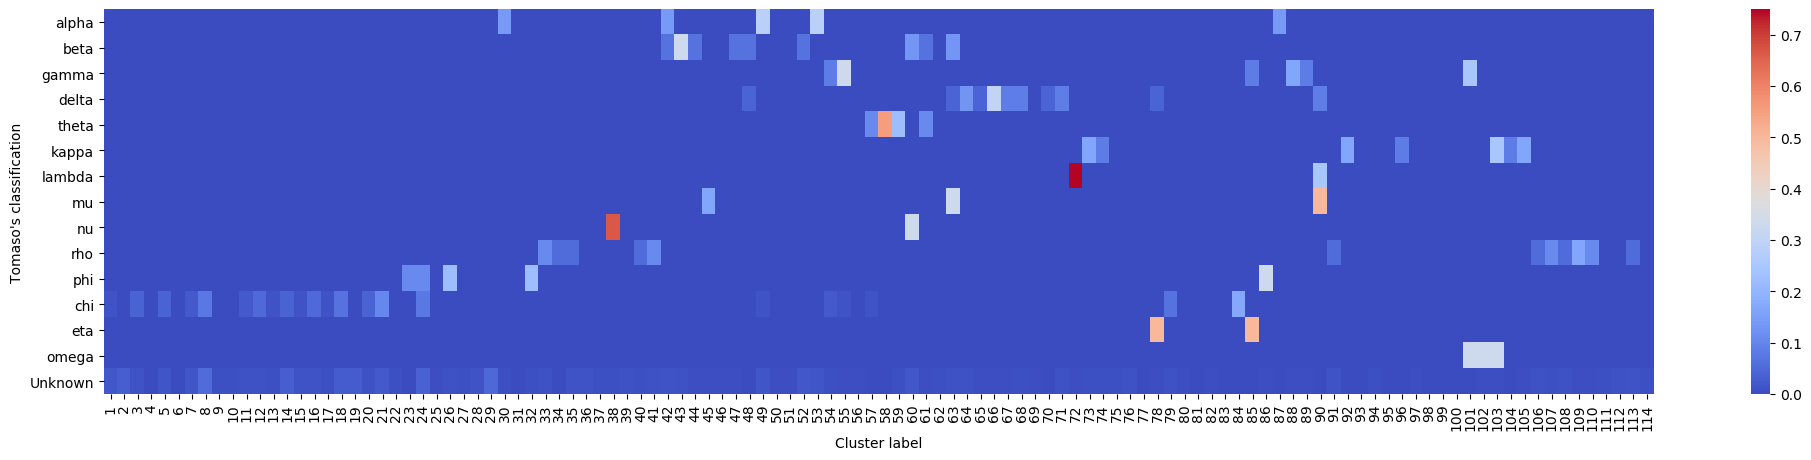

In [116]:
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = [25,5]
# normalized
cf_mx = confusion_matrix(obs_classes_ind, cluster_labels, normalize="true")
sns.heatmap(cf_mx[:15,:], cmap='coolwarm', yticklabels=Belloni_classes, xticklabels=True)
# ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 7)
plt.ylabel("Tomaso's classification")
plt.xlabel("Cluster label")
plt.xlim([1,115])
plt.show()

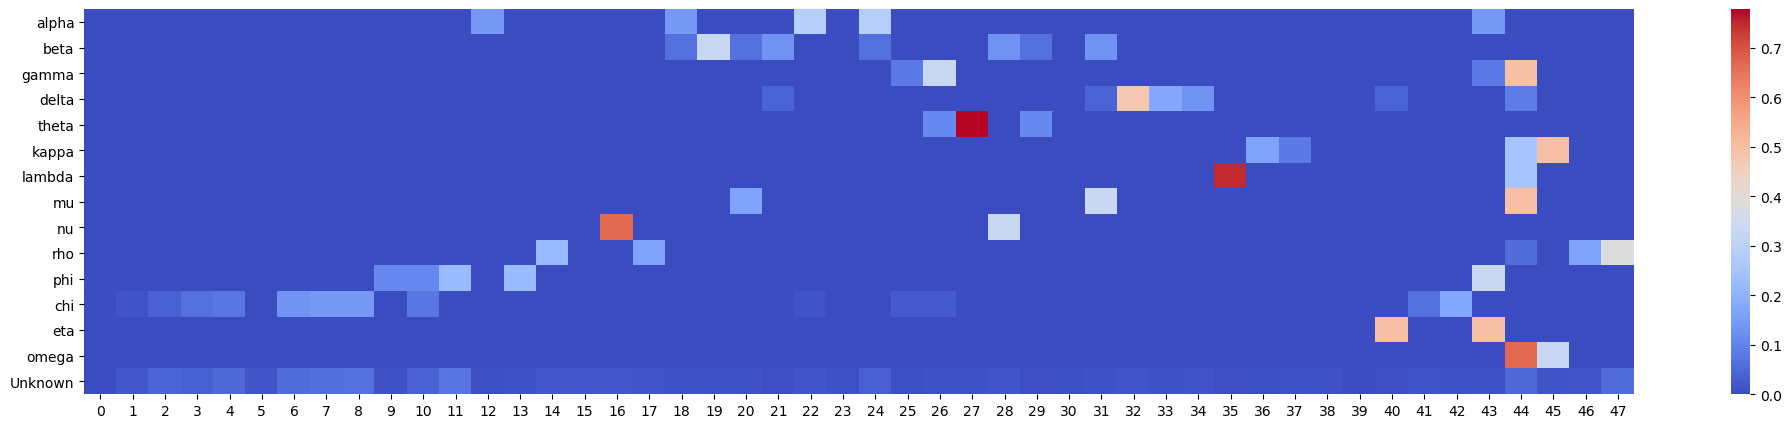

In [48]:
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = [25,5]
# normalized
cf_mx = confusion_matrix(obs_classes_ind, fcluster(linkage, 1.02, criterion='distance'), normalize="true")
sns.heatmap(cf_mx[:15,:], cmap='coolwarm', yticklabels=Belloni_classes)
plt.show()

In [175]:
inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

In [176]:
inv_ob_state

{'alpha': ['20187-02-01-00',
  '20187-02-01-01',
  '20402-01-22-00',
  '20402-01-23-00',
  '20402-01-24-01',
  '20402-01-27-00',
  '20402-01-28-00',
  '20402-01-30-02'],
 'beta': ['10408-01-10-00',
  '10408-01-21-00',
  '20402-01-43-02',
  '20402-01-44-00',
  '20402-01-45-03',
  '20402-01-46-00',
  '20402-01-52-01',
  '20402-01-52-02',
  '20402-01-53-00',
  '40703-01-18-00',
  '40703-01-19-00',
  '40703-01-19-01',
  '40703-01-22-00',
  '40703-01-22-01',
  '40703-01-35-00',
  '40703-01-35-01'],
 'gamma': ['20402-01-37-00',
  '20402-01-37-02',
  '20402-01-38-00',
  '20402-01-39-00',
  '20402-01-39-02',
  '20402-01-40-00',
  '20402-01-55-00',
  '20402-01-56-00',
  '20402-01-57-00',
  '40703-01-13-00',
  '40115-01-07-00',
  '40703-01-31-00'],
 'delta': ['10408-01-14-00',
  '10408-01-14-01',
  '10408-01-14-02',
  '10408-01-14-03',
  '10408-01-14-04',
  '10408-01-14-05',
  '10408-01-14-07',
  '10408-01-14-08',
  '10408-01-14-09',
  '10408-01-17-00',
  '10408-01-17-03',
  '10408-01-18-01',
  

In [54]:
with open('{}/1776_light_curves_1s_bin_errorfix.pkl'.format(data_dir), 'rb') as f:
    lcs = pickle.load(f)
with open('{}/1776_light_curves_1s_bin_ids_errorfix.pkl'.format(data_dir), 'rb') as f:
    ids = pickle.load(f)

In [ ]:
plt.close()

counts_todo = [i for i,v in normalized_comparison_matrix_df["Unknown"].sort_values(ascending=False)[:10].items() if v>=0.5]

if len(counts_todo) > 3:
    how_many_to_plot = 10
else:
    how_many_to_plot = 20

plt.rcParams['figure.figsize'] = (10,how_many_to_plot)
plt.rcParams.update({'font.size': 12})

counts = np.unique(shape_moments_GM114_labels, return_counts=1)

for ind, new_class in enumerate(counts[0][np.argsort(counts[1])[::-1]]):
    if new_class not in counts_todo: continue
    class_segments = np.where(shape_moments_GM114_labels == new_class)[0]
    fig, axes = plt.subplots(nrows=how_many_to_plot, ncols=2)
    
    for subplot in range(how_many_to_plot):
        data = segments_counts[class_segments[subplot]]
        reconstruction = segment_reconstructions[class_segments[subplot]]
        class_name = segment_class[class_segments[subplot]]
        axes[subplot, 0].plot(np.array(list(range(128)))*4,segments_counts[class_segments[subplot]])#, c="green", linewidth=0.5, zorder=-5)
        axes[subplot, 0].plot(np.array(list(range(128)))*4, reconstruction*np.std(data)+np.mean(data))
        axes[subplot, 1].plot(np.array(list(range(128)))*4,segments_counts[class_segments[subplot]])
        axes[subplot, 1].plot(np.array(list(range(128)))*4, reconstruction*np.std(data)+np.mean(data))
        axes[subplot, 1].set_ylim([0, 13000])
        if class_name == "Unknown": 
            class_name = "??"
        else:
            class_name = r"$\{}$".format(class_name)
        axes[subplot, 1].text(x=510, y=9500, s=class_name)
    plt.suptitle("component {}, population {}".format(new_class, np.sort(counts[1])[::-1][ind]), y=1.01)
    plt.tight_layout()
    plt.show()


<Figure size 1000x800 with 0 Axes>

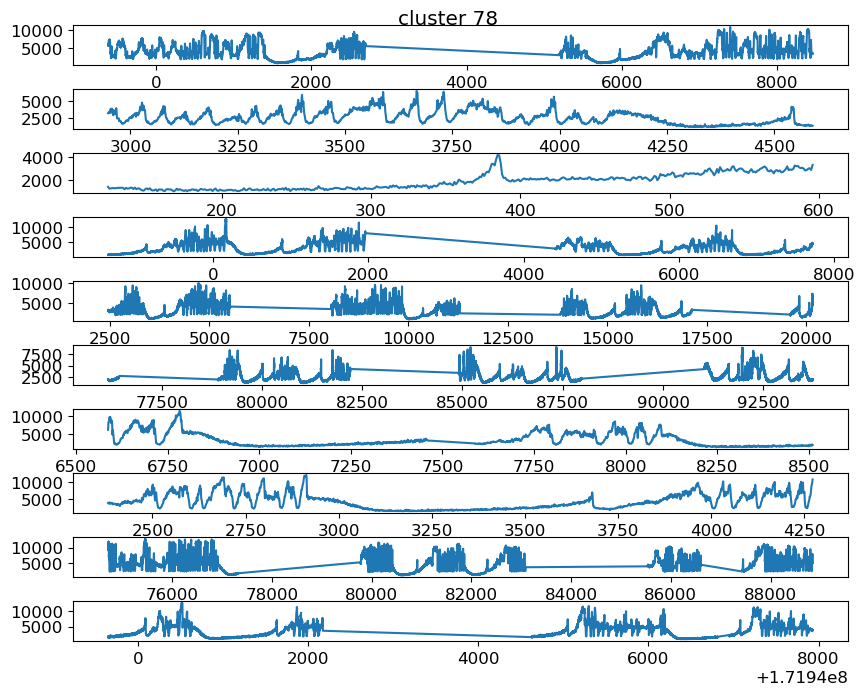

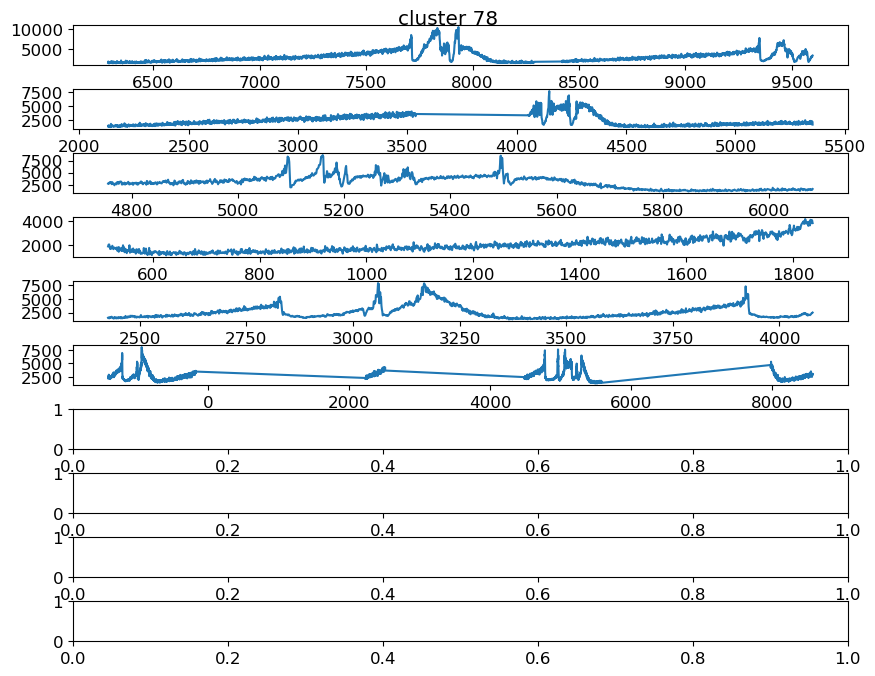

In [191]:
#nu 38 60
#eta 78, 85
cluster_no = 78
nrows = 10
plt.close()
plt.tight_layout()
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(nrows=nrows, ncols=1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
plt.suptitle("cluster {}".format(cluster_no), y=0.9)
# lcs_of_interest = standardised_obs_component_counts_df_500.index.values[np.where(cluster_labels == cluster_no)[0]]#
lcs_of_interest = inv_ob_state["beta"]#
for n_plot, lc_oi in enumerate(lcs_of_interest):
    index_oi = np.where(np.array(ids) == lc_oi)[0][0]
    axes[n_plot%nrows].plot(lcs[index_oi][0], lcs[index_oi][1])
    if (n_plot%(nrows-1) == 0) and n_plot>0:
        plt.show()
        fig, axes = plt.subplots(nrows=nrows, ncols=1)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
        plt.suptitle("cluster {}".format(cluster_no), y=0.9)
    elif (n_plot == len(lcs_of_interest)-1):
        plt.show()

In [193]:
len(inv_ob_state["beta"])

16

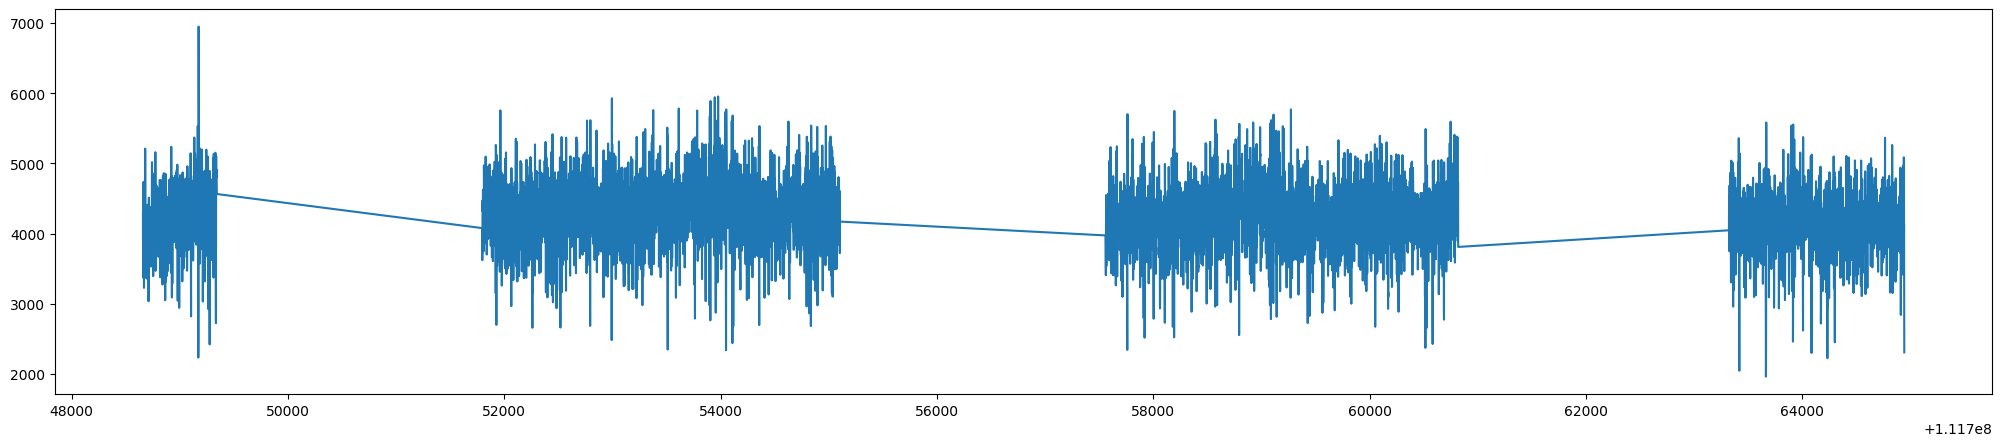

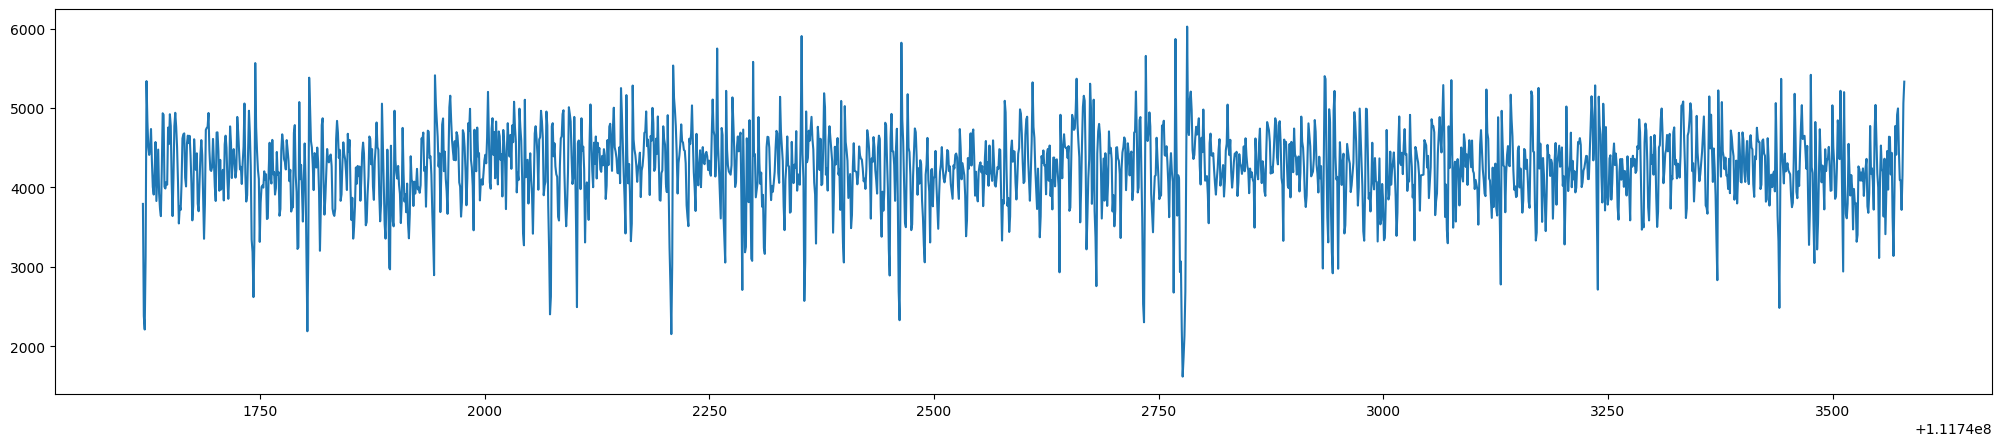

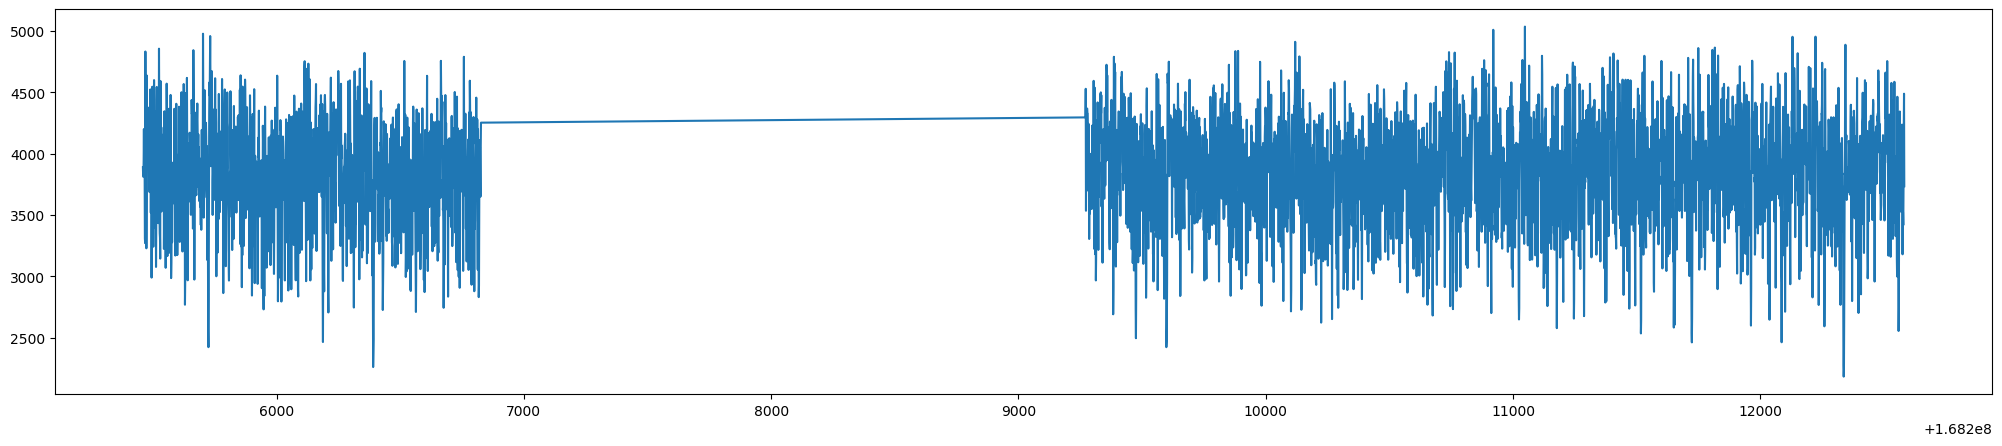

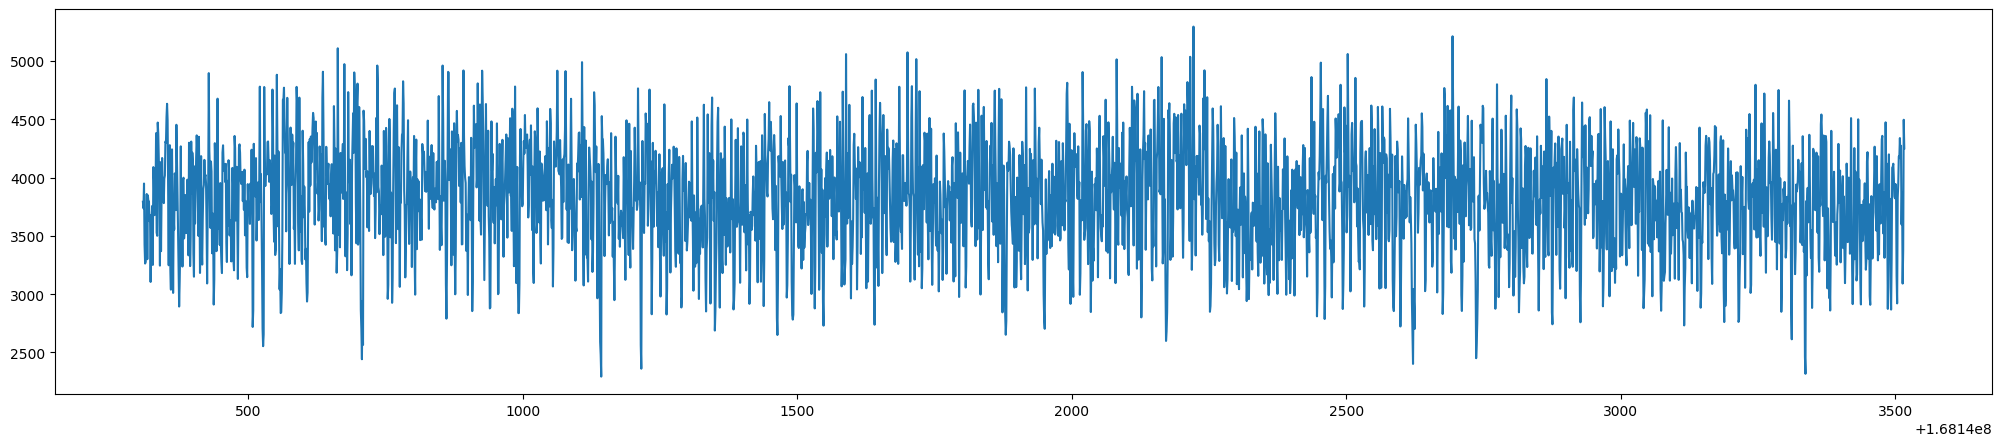

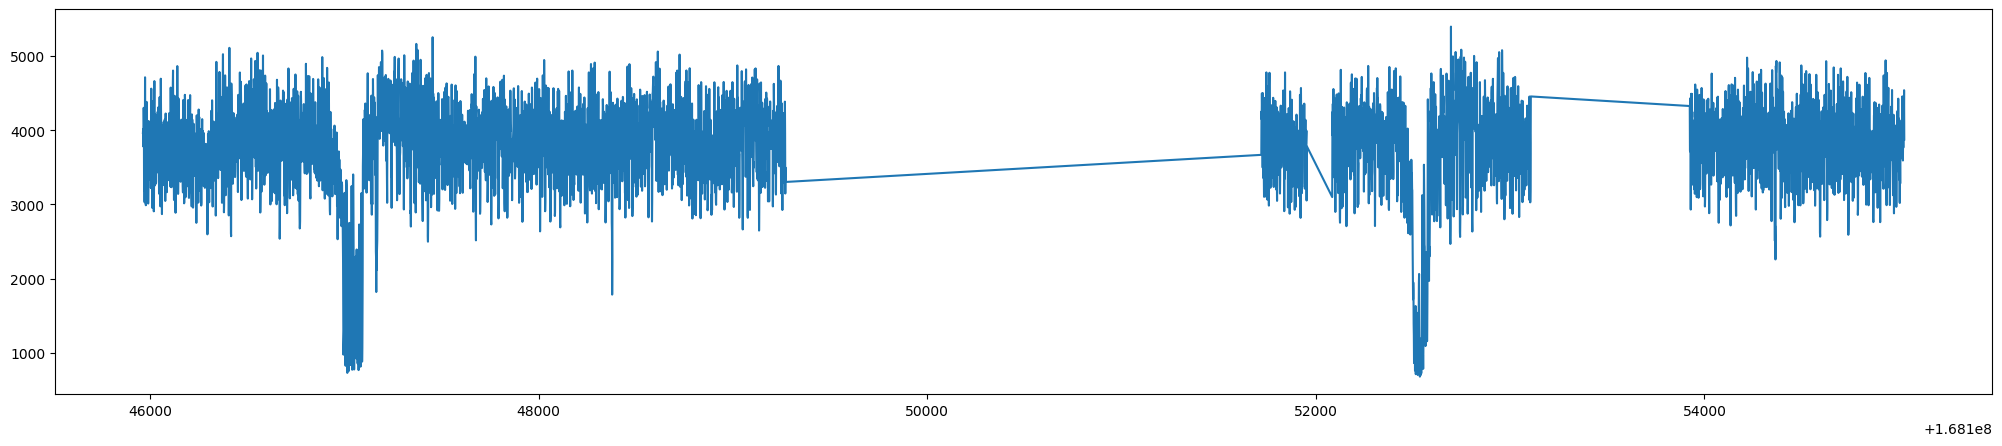

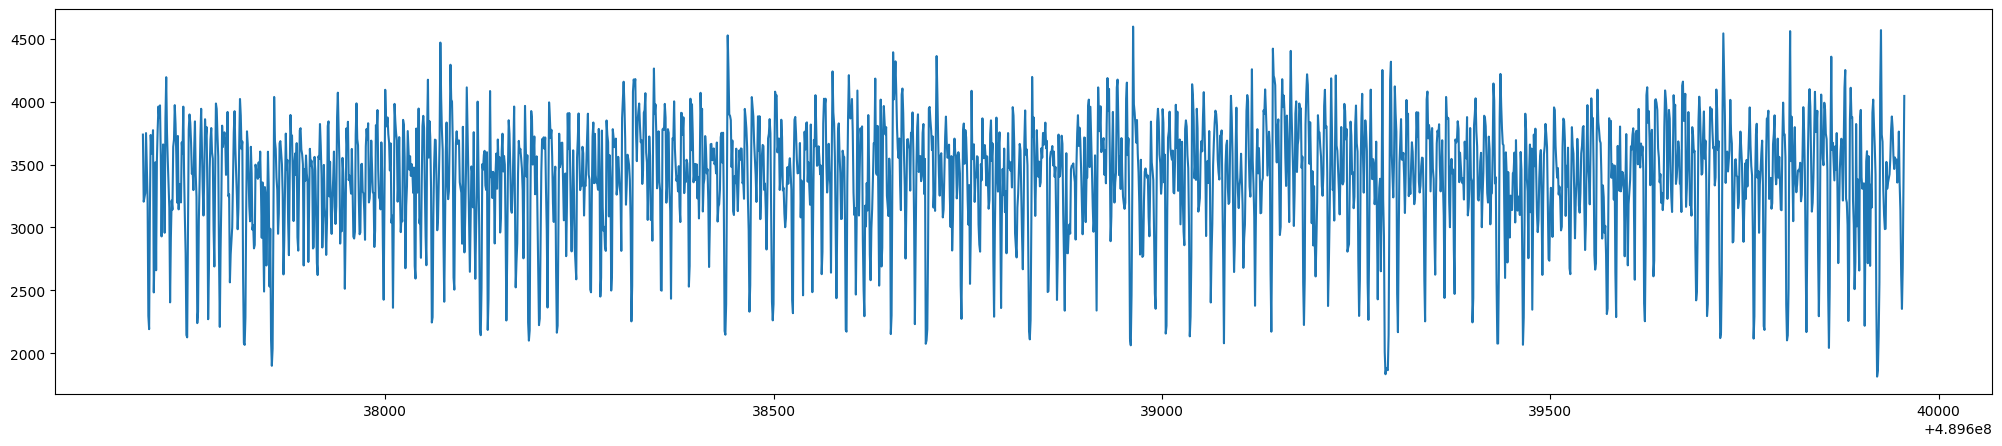

In [124]:
lcs_of_interest = standardised_obs_component_counts_df_500.index.values[np.where(cluster_labels == 101)[0]]
for lc_oi in lcs_of_interest:
    index_oi = np.where(np.array(ids) == lc_oi)[0][0]
    plt.plot(lcs[index_oi][0], lcs[index_oi][1])
    plt.show()

# Load data

In [2]:
# load list of unique IDs for light curve segments: observationID_segmentIndex,
# i.e. ['96701-01-48-00_3','20402-01-02-02_122','70703-01-01-000_1420', ...]
with open('{}/468202_len128_s2_4cad_ids_errorfix.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)
    
# load observation classifications from Huppenkothen+2017
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))

# Load component labels under the 500 components for 468202 segments
# i.e. array([458, 278,  30, ..., 358, 450, 400])
with open('{}/shape_moments_GM500_labels.pkl'.format(data_dir), 'rb') as f: # 500 component Gausssian mixture model fit to the 468202 20d samples
    shape_moments_GM500_labels = pickle.load(f)

# Build a dataframe containing counts of light curve segments in each Gaussian mixture component for each observation
shape : [1738, 500]

In [3]:
# make a dict of Tomaso's classifications against observation ids,
# i.e. ob_state == {'20187-02-01-00': 'alpha', '20187-02-01-01': 'alpha', '20402-01-22-00': 'alpha', ...}
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

# make a list of observation id which each of the segments comes from
#i.e. ['96701-01-48-00','20402-01-02-02', '70703-01-01-000',
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs for each segment

In [4]:
# make a dictorionary that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

In [5]:
# make a dictionary of Gaussian component indices instead of segment indices  
#i.e. ObID_GaussComps_dict_500 == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_500 = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_500[ObID] = [shape_moments_GM500_labels[ind] for ind in Indices]

In [6]:
ObID_GaussComps_dict_500['10258-01-01-00'][-2:]

[101, 152]

In [7]:
# make a data frame containing the counts of light curve segments in each of the Gaussian components for each observation
obs_component_counts_df_500 = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_500),len(np.unique(shape_moments_GM500_labels)))), index=np.unique(seg_ObIDs), columns=list(range(500)), dtype=int)

In [8]:
# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_500.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_500.loc[ObID][comp_id] = comp_count

# obs_component_counts_df_500.sum().values.min() returns 59, so each one of the 500 components is populated with something

In [10]:
from sklearn import preprocessing

# apply mean centering and variance scaling to values in each row of the data frame
standardised_obs_component_counts_df_500 = pd.DataFrame(preprocessing.scale(obs_component_counts_df_500, axis=1), index=np.unique(seg_ObIDs), columns=list(range(500)))
standardised_obs_component_counts_df_500

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
10258-01-01-00,-0.192533,-0.192533,0.613888,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,...,-0.192533,0.009072,-0.192533,1.017098,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533
10258-01-02-00,-0.189176,-0.189176,2.804109,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,...,-0.189176,0.409481,-0.189176,0.609034,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176
10258-01-03-00,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,...,-0.144074,-0.144074,-0.144074,-0.061082,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074
10258-01-04-00,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,...,-0.110966,-0.110966,-0.110966,0.216367,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966
10258-01-05-00,1.349320,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,...,-0.200096,0.021249,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,...,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177
96701-01-51-00,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,...,-0.120367,-0.120367,-0.120367,0.407559,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367
96701-01-51-01,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,...,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700
96701-01-52-00,4.811076,-0.136894,3.574083,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,...,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894


In [34]:
# load light curve segments
with open('{}/468202_len128_s2_4cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-04-29_09-12-23.h5"
segments_dir = '../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 16 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape [468202, 20]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

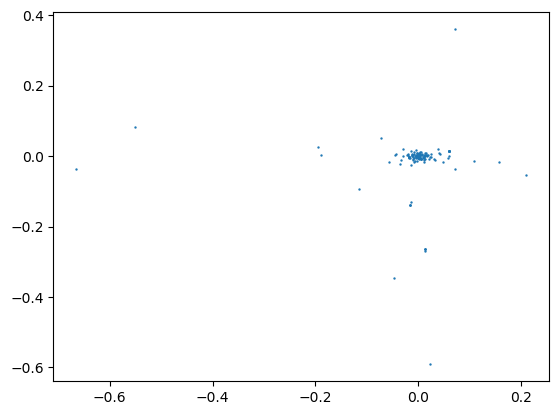

In [36]:
# from sklearn.manifold import Isomap
# embedding = Isomap(n_components=2)
# X_transformed = embedding.fit_transform(shape_moments)
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=0.5)
plt.show()

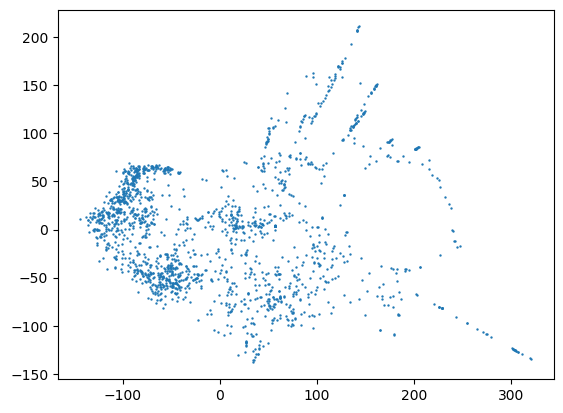

In [24]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(standardised_obs_component_counts_df_500)
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=0.5)
plt.show()

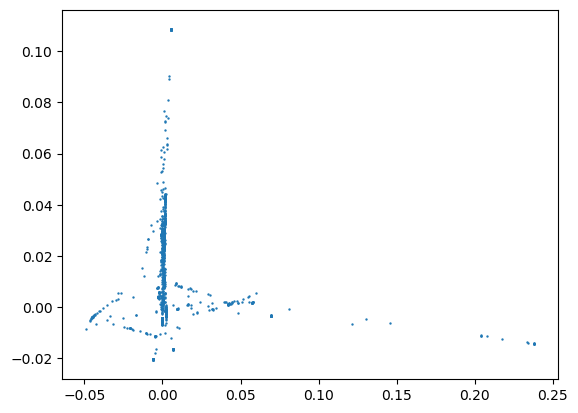

In [23]:
from sklearn.manifold import LocallyLinearEmbedding
embedding = LocallyLinearEmbedding(n_components=2)
X_transformed = embedding.fit_transform(standardised_obs_component_counts_df_500)
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=0.5)
plt.show()

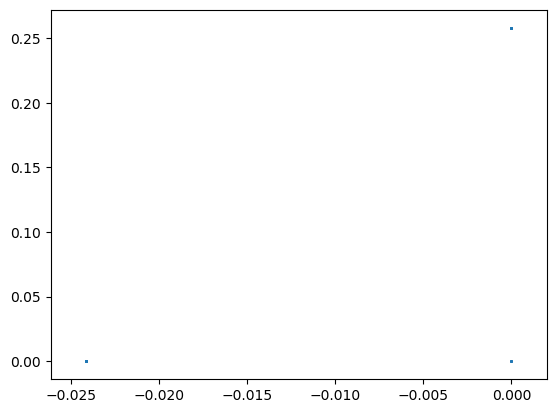

In [28]:
from sklearn.manifold import LocallyLinearEmbedding
embedding = LocallyLinearEmbedding(n_components=2, method="modified")
X_transformed = embedding.fit_transform(standardised_obs_component_counts_df_500)
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=0.5)
plt.show()

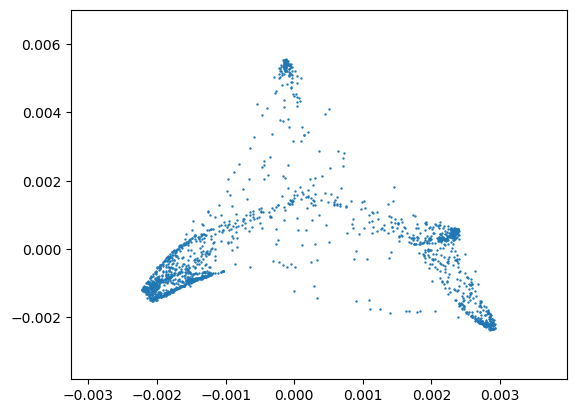

In [29]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=2)
X_transformed = embedding.fit_transform(standardised_obs_component_counts_df_500)
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=0.5)
plt.show()

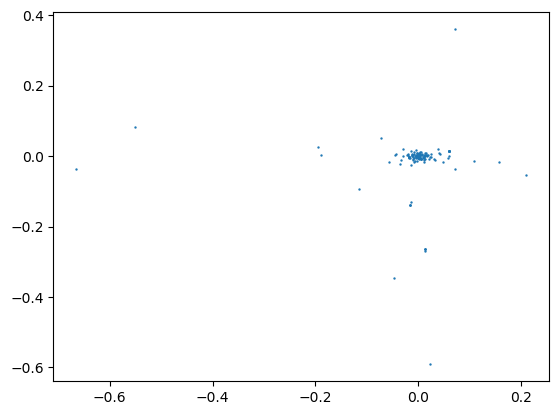

In [33]:
from sklearn.manifold import LocallyLinearEmbedding
embedding = LocallyLinearEmbedding(n_components=2, method="ltsa", eigen_solver='dense')
X_transformed = embedding.fit_transform(standardised_obs_component_counts_df_500)
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=0.5)
plt.show()

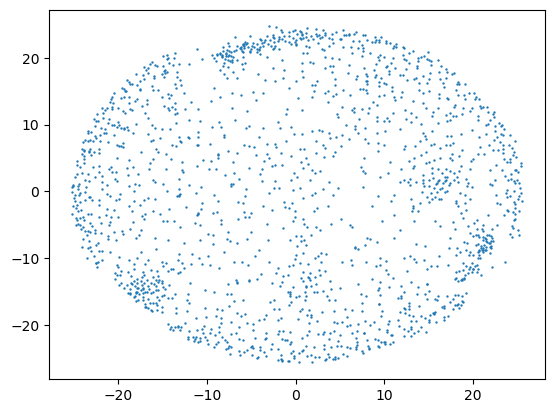

In [31]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(standardised_obs_component_counts_df_500)
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=0.5)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2)
X_transformed = embedding.fit_transform(standardised_obs_component_counts_df_500)
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=0.5)
plt.show()

In [37]:
bics = np.loadtxt('gaussian_mixture_bics.csv', delimiter=",")

120
112
116


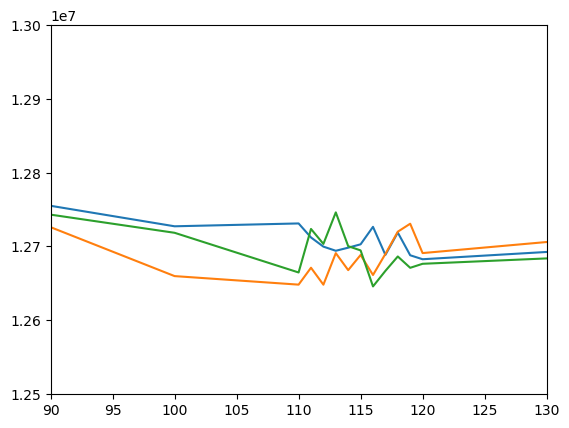

In [43]:
component_no_list = [10,25,50,70,80,90,100,110,111,112,113,114,115,116,117,118,119,120,130,140,150,200,300]
for dataset_bics in bics:
    print(component_no_list[np.argmin(dataset_bics)])
    plt.plot(component_no_list,dataset_bics)
plt.xlim([90,130])
plt.ylim([1.25e7, 1.3e7])
plt.show()

In [65]:
# with open('{}/1776_light_curves_1s_bin.pkl'.format(data_dir), 'rb') as f:
#     lcs = pickle.load(f)
# with open('{}/1776_light_curves_1s_bin_ids.pkl'.format(data_dir), 'rb') as f:
#     ids = pickle.load(f)
    
# start_times = []
# for lc in lcs:
#     start_times.append(lc[0][0])
    
# ordered_ob_ids = np.array(ids)[np.argsort(np.array(start_times))]

# ids_df = pd.DataFrame({"seg_ids": seg_ids, "ob_id": [seg.split("_")[0] for seg in seg_ids], "index": np.array([seg.split("_")[1] for seg in seg_ids], dtype=int)})

# sorted_segments = []
# for ob in ordered_ob_ids:
#     sorted_segments = np.hstack((sorted_segments, np.array(ids_df[ids_df["ob_id"] == ob].sort_values("index").seg_ids)))

# chrono_clusters = []
seg_ids_arr = np.array(seg_ids)
for iteration, curr_seg in enumerate(sorted_segments[38899:]):
    shuffled_index = np.where(seg_ids_arr == curr_seg)[0][0]
    chrono_clusters.append(shape_moments_GM500_labels[shuffled_index])
    print(iteration+38899)
    clear_output(wait=True)
# chrono_latent_coords = []
# for curr_seg in sorted_segments:
#     curr_ind = np.where(np.array(seg_ids) == curr_seg)[0][0]
#     chrono_latent_coords.append(embeddings_lap[curr_ind])
    
# chrono_latent_coords = np.asarray(chrono_latent_coords)

# rev_chrono_latent_coords = np.flip(chrono_latent_coords, axis=0)

468201


In [67]:
# with open('{}/GMM_500comp_labels_chronologically.pkl'.format(data_dir), 'wb') as f:
#     pickle.dump(chrono_clusters, f)

In [3]:
with open('{}/468202_len128_s2_4cad_start_times_errorfix.pkl'.format(data_dir), 'rb') as f:
    seg_id_start_time_df = pickle.load(f)
    
JD_times = np.sort(seg_id_start_time_df.Start_time.values)

    
with open('{}/GMM_500comp_labels_chronologically.pkl'.format(data_dir), 'rb') as f:
    chrono_clusters = pickle.load(f)
    
with open('{}/GMM_shape16_moments4_components500_alldata.pkl'.format(data_dir), 'rb') as f:
    GMM_500 = pickle.load(f)
    
from sklearn.cluster import OPTICS

clustering = OPTICS().fit(GMM_500.means_)
reordered_chrono_clusters = clustering.ordering_[chrono_clusters]



plt.rcParams['figure.figsize'] = [100,5]
for interval in np.arange(0,468202, 20000):
    plt.scatter(JD_times[interval:interval+20000], reordered_chrono_clusters[interval:interval+20000])
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../../data_GRS1915/468202_len128_s2_4cad_start_times_errorfix.pkl'

In [13]:
np.sort(seg_id_start_time_df.Start_time.values)

array([7.13867574e+07, 7.13867654e+07, 7.13867734e+07, ...,
       5.68004512e+08, 5.68004520e+08, 5.68004528e+08])

In [7]:
# with open('../../../files_from_snuffy/468202_len128_s2_4cad_start_times_errorfix.pkl', 'wb') as f:
#     pickle.dump(seg_id_start_time_df, f)
    
    
with open('{}/468202_len128_s2_4cad_start_times_errorfix.pkl'.format(data_dir), 'rb') as f:
    seg_id_start_time_df = pickle.load(f)
    
np.sort(seg_id_start_time_df.Start_time.values)

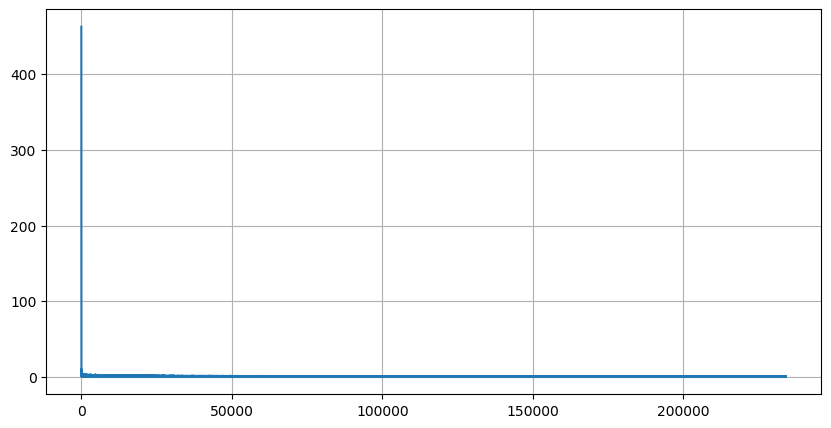

In [89]:
from scipy.fft import fft
plt.rcParams['figure.figsize'] = [10,5]

# Number of sample points
N = 468202
# sample spacing
T = 1.0/468202
y = reordered_chrono_clusters
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [90]:
plt.rcParams['figure.figsize'] = [100,5]
plt.scatter(chrono_clusters[:10000])
plt.show()

TypeError: scatter() missing 1 required positional argument: 'y'

In [ ]:
#try OPTICS on means of the  Gaussian mixture components to get the order of components in terms of proximity, this might be a nice order to put the labels in.

In [70]:
with open('{}/GMM_shape16_moments4_components500_alldata.pkl'.format(data_dir), 'rb') as f:
    GMM_500 = pickle.load(f)

In [73]:


from sklearn.cluster import OPTICS

clustering = OPTICS().fit(GMM_500.means_)

array([-1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  5, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  6, -1, -1, -1,
        2, -1, -1, -1,  4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  6,
       -1, -1, -1, -1, -1, -1, -1,  3, -1,  5, -1, -1, -1, -1, -1, -1, -1,
        5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1, -1,  4,  6,  6, -1, -1, -1, -1,  2,
       -1, -1,  6, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [77]:
clustering.reachability_[clustering.ordering_] 

array([       inf, 2.03690934, 2.03690934, 2.03690934, 1.78327957,
       1.78327957, 1.88641669, 1.88641669, 1.79591783, 1.4457797 ,
       1.1331854 , 1.1331854 , 1.1331854 , 1.00620131, 0.88741486,
       0.88741486, 0.88741486, 0.91688422, 0.79649647, 0.79649647,
       0.79649647, 0.79649647, 0.81905933, 0.81905933, 0.84538211,
       0.88348927, 0.896584  , 0.896584  , 0.91688422, 0.92305987,
       0.92305987, 0.91887881, 0.86590066, 0.86590066, 0.8290331 ,
       0.76105669, 0.76105669, 0.76105669, 0.8290331 , 0.8290331 ,
       0.89372235, 0.92305987, 0.92499165, 0.93249245, 0.94111429,
       0.95150012, 0.9740495 , 0.9757847 , 0.98959874, 0.99189375,
       0.99391937, 0.99607509, 0.99652299, 1.00543889, 1.00620131,
       1.03453693, 1.04099456, 1.04498038, 1.0461125 , 1.05603289,
       1.06136105, 1.07016364, 1.07200202, 1.07854089, 1.08115659,
       1.1045568 , 1.11066271, 1.12229558, 1.12229558, 1.12229558,
       1.1331854 , 1.14516376, 1.15186767, 1.15336024, 1.16093

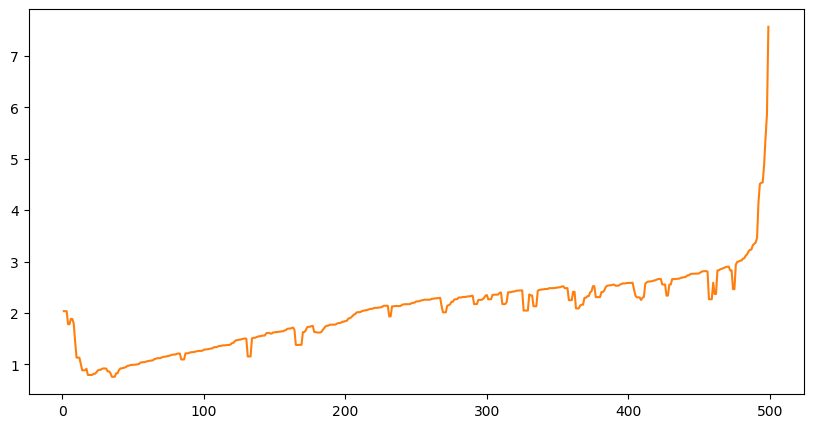

In [79]:
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(clustering.reachability_[clustering.ordering_] )
plt.show()

In [83]:
reordered_chrono_clusters

array([ 70,  70,  70, ..., 102, 232, 232])

In [82]:
reordered_chrono_clusters = clustering.ordering_[chrono_clusters]

In [104]:
lengths = []
for lc in lcs:
    lengths.append(len(lc[0]))

In [116]:
np.sum(((np.array(lengths)<=512) & (np.array(lengths)<1200)))

34

In [112]:
lcs[0][0][1]-lcs[0][0][0]

1.0

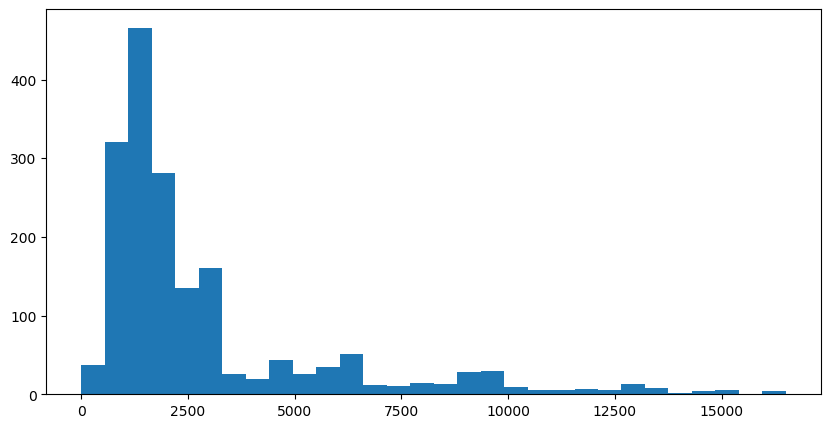

In [107]:
plt.rcParams['figure.figsize'] = [10,5]

plt.hist(lengths, bins=30)
plt.show()